# Variational Autoencoder on Dogs vs. Cats

## Importing required libraries

In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import os
from os import listdir
import sys
import random 

import plotly
import plotly.express as px
main_dir=os.path.dirname(sys.path[0])

Using TensorFlow backend.


## Preparing the dataset
The dataset is loaded from disk and the RGB values are normalized. The dataset is then reshaped to a shape approriate for being fed to the VAE.

In [2]:
def read_img(directory):
    imgs = []
    for img in os.listdir(directory):
        i = 0
        if (img.endswith(".jpg") and img is not None):
            with Image.open(directory+"/"+img) as image:  
                image = image.resize((64,64))
                im = np.array(image)
                if im.shape == (64,64,3):
                    im = im.astype(np.float32)                 
                    imgs.append(im/255)
                else:
                    i+=1  
    return imgs

In [3]:
dogs = read_img(main_dir+"/VAE/PetImages/Dog")
cats = read_img(main_dir+"/VAE/PetImages/Cat")

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Defining the architecture
### Sampling
In this part a method is defined in which a reparameterisation trick is leveraged. Despite the random sampling that occurs from the latent space, the loss needs to backpropagate through it to make the training possible. Thus, the variable epsilon is defined which is randomly sampled from the normal distribution and using the formula below the sampling is done from the latent space: <br>
means + standard_deviations*epsilon

In [5]:
def sample(means_log_var):
    means, log_var = means_log_var
    epsilon = K.random_normal(shape=(K.shape(means)[0], latent_dim), mean=0, stddev=1)
    return means + K.exp(log_var/2) * epsilon

### Defining the encoder
The encoder part of the VAE is consisted of four 2-dimensional Convolutional layers followed by a flattening and a dense layer. It outputs the means and logarithms of the variances of the latent space distributions and the sample.

In [7]:
img_shape = (64, 64, 3)
latent_dim = 128

input_layer = keras.Input(shape=img_shape)
x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input_layer)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
shape = K.int_shape(x)
print(shape)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)


means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = Model(input_layer, [means, log_var, z])
print(encoder.summary())

(None, 32, 32, 128)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 128)  73856       conv2d_6[0][0]                   
________________________________________________________________________

### Defining the decoder
The decoder has to be defined in a manner that results in a final output with the same shape as the input images. Here, the architecture consists of a dense layer (with the same number of parameters as before flattening in the encoder part), a reshaping layer (turining the flattened data to their shape before flattening) and 2-dimenstional transpose convolutional and convolutional layers.

In [8]:
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(shape[1]*shape[2]*shape[3],activation='relu')(decoder_input)
x = keras.layers.Reshape(shape[1:])(x)
x = keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
outputs = keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, outputs)
print(decoder.summary())
x_prime = decoder(z)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 131072)            16908288  
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        36896     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 3)         867       
Total params: 16,946,051
Trainable params: 16,946,051
Non-trainable params: 0
_________________________________________________________________
None


### Defining the loss function
The loss function is consisted of two parts: 1) The reconstruction term and 2) The regularisation term.
While the reconstruction term (usually scaled crossentropy or MSE) ensures an accurate reconstruction of the images, the regularisation term ensures a regularised organisation of the latent space by making the distributions close to a standard normal distribution (ensuring the continuty and completeness of the latent space).

In [12]:
def my_loss(x, x_prime):
    x = K.flatten(x)
    x_prime = K.flatten(x_prime)
    reconstruct_loss = 64*64*keras.metrics.binary_crossentropy(x, x_prime)
    kl_loss = -0.5* K.sum(1 + log_var - K.square(means) - K.exp(log_var), axis = -1)
    return K.mean(reconstruct_loss + kl_loss)


### Defining the VAE
In this part, the encoder and decoder parts are connected.

In [13]:
outputs = decoder(encoder(input_layer)[2])
vae = Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam")
print(vae.summary())       


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
model_2 (Model)              [(None, 128), (None, 128) 4443616   
_________________________________________________________________
model_3 (Model)              (None, 64, 64, 3)         16946051  
Total params: 21,389,667
Trainable params: 21,389,667
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [14]:
dataset = [y for x in [dogs, cats] for y in x]
random.shuffle(dataset)
print(len(dataset))
his = vae.fit(np.array(dataset),np.array(dataset) , epochs = 3, batch_size = 233, validation_split = 0.2)

24931
Train on 19944 samples, validate on 4987 samples
Epoch 1/3
19944/19944 [==============================] - 527s 26ms/step - loss: 2776.0980 - val_loss: 2705.6828
Epoch 2/3
19944/19944 [==============================] - 553s 28ms/step - loss: 2663.9961 - val_loss: 2652.9635
Epoch 3/3
19944/19944 [==============================] - 549s 28ms/step - loss: 2648.5748 - val_loss: 2646.2788


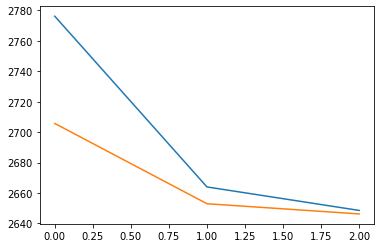

In [15]:
plt.plot(his.history['loss'], label='loss')
plt.plot(his.history['val_loss'], label = 'val_loss')

## Sample Generation

In [71]:
def generate_image(count):
    start = 1660
    x = encoder.predict(np.array(dataset[start:start+count]))
    ax = []
    for i in range(count):
        t = []
        for j in range(128):
            t.append(30*random.uniform(0, 1)-15)
        ax.append(np.array(t))
   
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   


    new_images = decoder.predict(x[2])
    new_images = new_images.reshape(count, 64, 64,3)
    for i in range(count):
        plt.subplot(count,2,2*i+1)
        plt.imshow(dataset[start+i])
        plt.subplot(count,2,2*i+2)
        plt.imshow(new_images[i])
    plt.show()
        
    


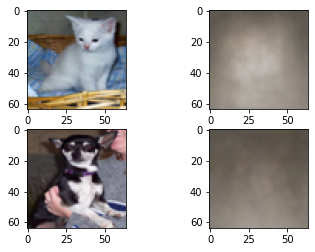

In [72]:
generate_image(2)